### Contexto

A base de dados que será estudada nesse projeto consta com diversas informações de saúde de pacientes localizados no Hospital de Frankfurt, na Alemanha. A base é destinada a informar quais são os pacientes com ou sem diabetes


### Objetivo Geral

Definir um modelo de classificação de Machine Learning capaz de classificiar com eficiência pacientes com diabetes

### Objetivos Específicos

- Trabalhar com novos conceitos: Oversamplig e Undersampling em dados desbalanceados
- Investigar mais a fundo sobre o conceito de Cross Validation
- Investigar mais a fundo sobre o conceito de Padronização x Normalização, quando ele se fazem necessários, qual e quando utilizar cada um

### Fonte

A base de dados foi retirada do site kaggle, podendo ser obtida em: https://www.kaggle.com/johndasilva/diabetes<br>
Como base para algumas discussões sobre os tópicos objetivos gerais e específicos do projeto utilizei os seguintes artigos:

    1. https://medium.com/@160shelf/comparing-machine-learning-algorithms-89a3b38d22a0
    2. https://www.upgrad.com/blog/cross-validation-in-machine-learning/
    3. https://www.journaldev.com/45025/standardscaler-function-in-python
    4. https://medium.com/data-hackers/normalizar-ou-padronizar-as-vari%C3%A1veis-3b619876ccc9
    5. https://www.jeremyjordan.me/imbalanced-data/

# Importando Bibliotecas

In [59]:
import pandas as pd
import pathlib 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

#Machine Learning Algorithms
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

#Performance
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Compreensão da Base

### Visualização Inicial

In [26]:
# Importando Base de Dados
df = pd.read_csv(r'diabetes.csv')
display(df)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0
...,...,...,...,...,...,...,...,...,...
1995,2,75,64,24,55,29.7,0.370,33,0
1996,8,179,72,42,130,32.7,0.719,36,1
1997,6,85,78,0,0,31.2,0.382,42,0
1998,0,129,110,46,130,67.1,0.319,26,1


- Podemos observar na última coluna a informação 'Outcome', ela será nossa coluna de estudo
- Ela indica se o paciente possui ou não diabetes
- Nosso objetivo será treinar um modelo capaz de classificar com eficiência pacientes com e sem diabetes

In [27]:
# Verificação colunas
print('\n'.join(list(df.columns)))

Pregnancies
Glucose
BloodPressure
SkinThickness
Insulin
BMI
DiabetesPedigreeFunction
Age
Outcome


### Descrição colunas

- Pregnancies: Número de gavidez
- Glucose: Glicose no Sangue 
- BloodPressure: Pressão Sanguínea (mmHg)
- SkinThickness: Expessura Pele 
- Insulin: Insulina 
- BMI: Índice de Massa Corporal  
- DiabetesPedigreeFunction: Probabilidade de desenvolver diabetes baseado no histórico familiar  
- Age: Idade
- Outcome: Saída de classificação para diabetes (1 --> positivo para diabetes, 0 --> negativo para diabetes)

### Análise inicial

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               2000 non-null   int64  
 1   Glucose                   2000 non-null   int64  
 2   BloodPressure             2000 non-null   int64  
 3   SkinThickness             2000 non-null   int64  
 4   Insulin                   2000 non-null   int64  
 5   BMI                       2000 non-null   float64
 6   DiabetesPedigreeFunction  2000 non-null   float64
 7   Age                       2000 non-null   int64  
 8   Outcome                   2000 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 140.8 KB


In [29]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,3.703500,121.182500,69.145500,20.935000,80.254000,32.193000,0.470930,33.090500,0.342000
std,3.306063,32.068636,19.188315,16.103243,111.180534,8.149901,0.323553,11.786423,0.474498
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,63.500000,0.000000,0.000000,27.375000,0.244000,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,40.000000,32.300000,0.376000,29.000000,0.000000
75%,6.000000,141.000000,80.000000,32.000000,130.000000,36.800000,0.624000,40.000000,1.000000
max,17.000000,199.000000,122.000000,110.000000,744.000000,80.600000,2.420000,81.000000,1.000000


- Um ponto muito positivo é que todos os valores estão preenchidos, não teremos problemas com tratamento de valorres vazios
- Todos os valores estão sendo lidos como números
- A um primeiro momento não vejo nenhuma necessidade de tratamento de dados ou feature engineering
- Os próximos passos serão destinados a entender da melhor forma possível os dados obtidos

# Análise Exploratória de Dados (AED)

### Análise Geral

<AxesSubplot:>

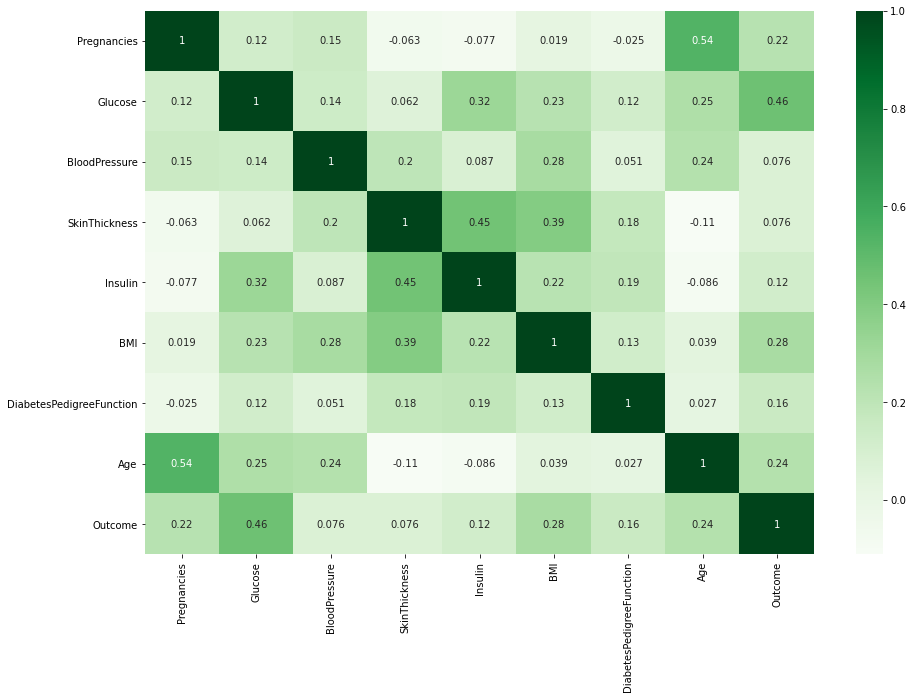

In [30]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), annot=True, cmap='Greens')

- Relações interessantes sobre a relação das colunas:<br>
    1. Idade e número de gravidez são as colunas com maior correlação, naturalmente quanto maior a idade da pessoa maior a chance delas ter tido mais filhos<br>
    2. O nível de Glicose é a coluna com maior correlação com a nossa coluna de interesse 'Outcome'<br>
    3. Esperava uma maior relação da coluna de pressão sanguínea com outras colunas, como idade e BMI<br>
    4. A medida referente a expessura da pele está mais relacionada com valores de insulina e BMI<br>
    5. Esperava uma relação maior entre as colunas DiabetesPedigreeFunction e a coluna 'Outcome'<br>

### Análise colunas

### Perfil dos Pacientes com / sem Diabetes

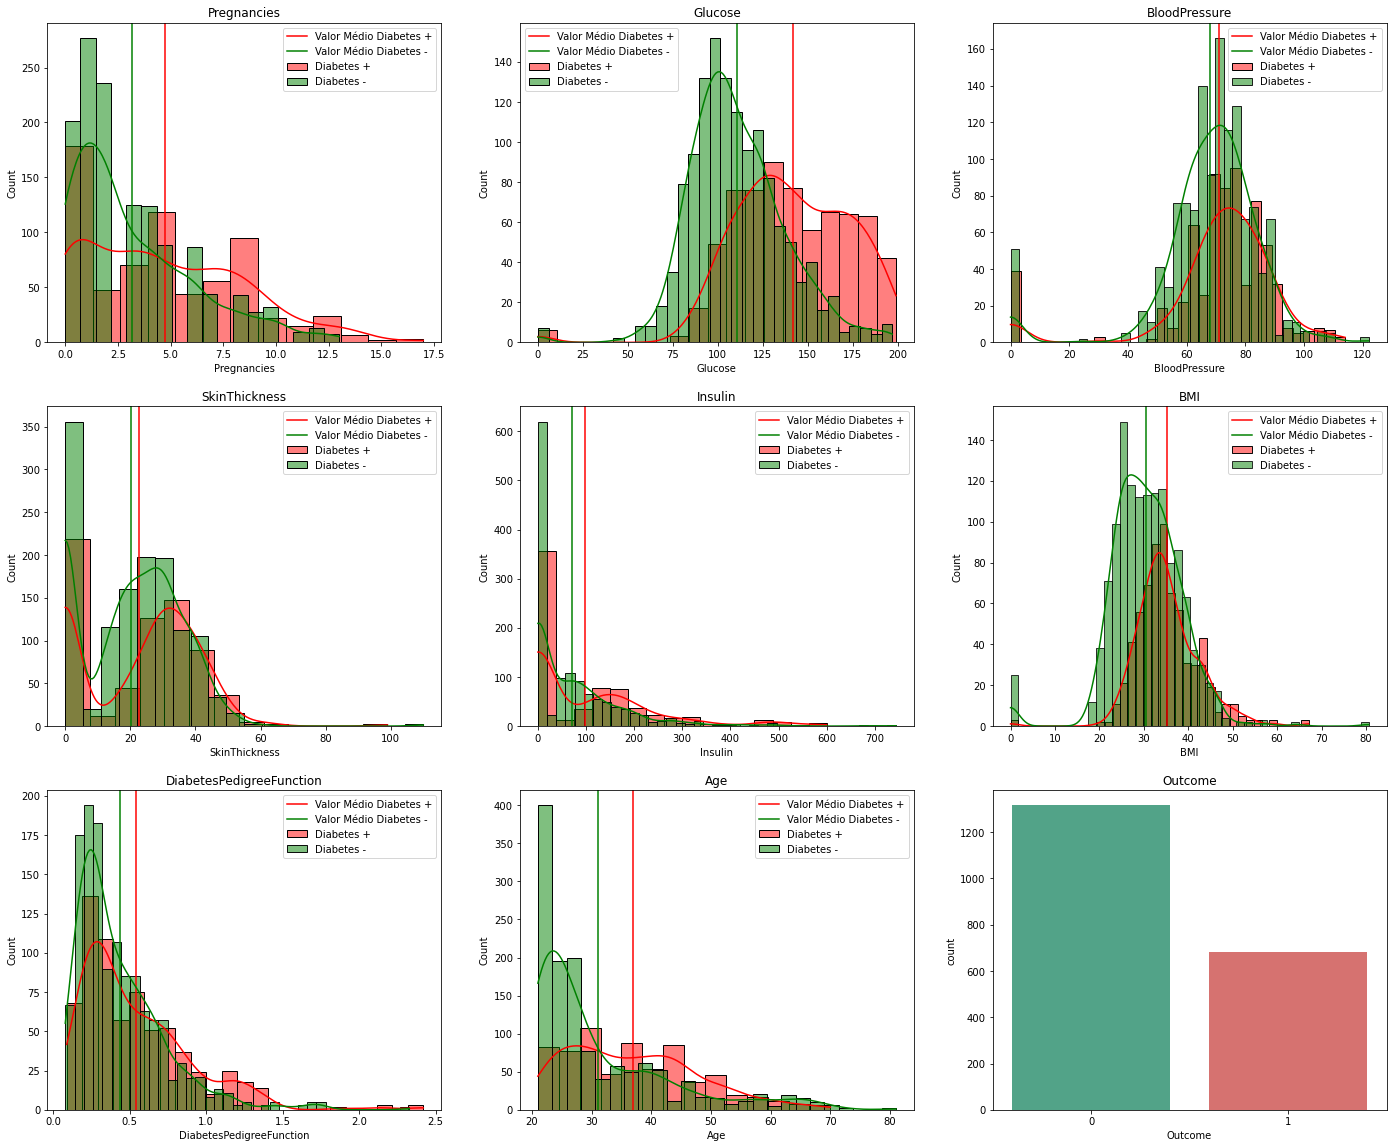

In [31]:
colunas_lt = list(df.columns)

diabetes_pos_df = df[df['Outcome'] == 1]
diabetes_neg_df = df[df['Outcome'] == 0]

plt.figure(figsize=(24,20))

# Histogramas
for i, coluna in enumerate(colunas_lt):
    if i == (len(colunas_lt)-1):
        plt.subplot(3,3,i+1)
        g = sns.countplot(x = coluna, data = df, palette = ['#45B08C','#E7625F'])
        g.set_title(coluna)

    else:
        plt.subplot(3,3,i+1)
        # Diabetes +
        g = sns.histplot(diabetes_pos_df[coluna], kde = True, color = 'r', label ='Diabetes +')
        mean1 = diabetes_pos_df[coluna].mean()
        plt.axvline(mean1, color = 'r', label = 'Valor Médio Diabetes +')
        # Diabetes -
        g = sns.histplot(diabetes_neg_df[coluna], kde = True, color = 'g', label ='Diabetes -')
        mean2 = diabetes_neg_df[coluna].mean()
        plt.axvline(mean2, color = 'g', label = 'Valor Médio Diabetes -')
        
        g.set_title(coluna)
        plt.legend()

plt.show()

- Os gráficos das colunas 'BloodPressure', 'SkinThickness', 'Insulin', 'DiabetesPedigreeFunction' possuem um perfil parecido entre os pacientes com e sem diabetes. Além disso o valor médio entre esses dois tipos de pacientes ficou relativamente próximo
- Pacientes com a métrica da coluna 'Glucose' mais elevados tendem a ter mais diabetes, é possível ver que o perfil do histograma em vermelho está deslocado para a direita
- Observando o gráfico de barra referente a coluna 'Outcome' é possível ver que existe muito mais pacientes sem diabetes. Isso pode nos trazer alguns problemas na fase de treinamento dos modelos, dados desbalanceados podem prejudicar os algoritmos de machine learning que aplicaremos (Irei abordar esse tipo de tratamento de dados no tópico 'Imbalanced Data'

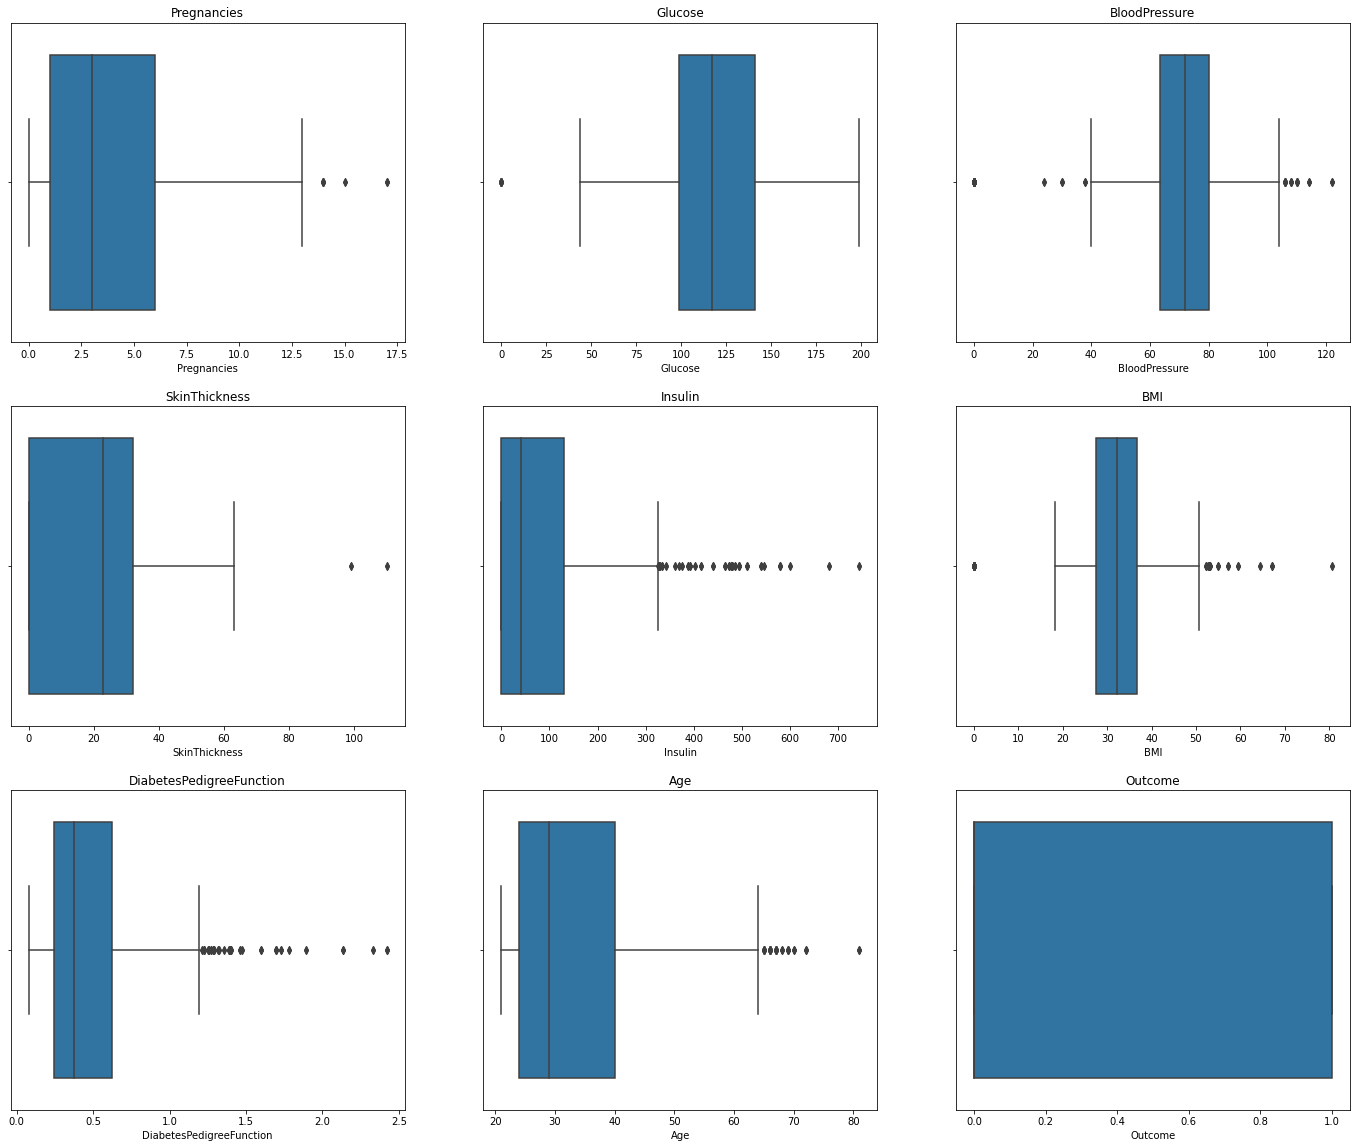

In [32]:
# Boxplots (perfil geral das colunas)
plt.figure(figsize=(24,20))

for i, coluna in enumerate(colunas_lt):
    plt.subplot(3,3,i+1)
    g = sns.boxplot(x = df[coluna])    
    g.set_title(coluna)

plt.show()

- Meu questionamento é saber se esses valores de outliers são pacientes com ou sem diabetes

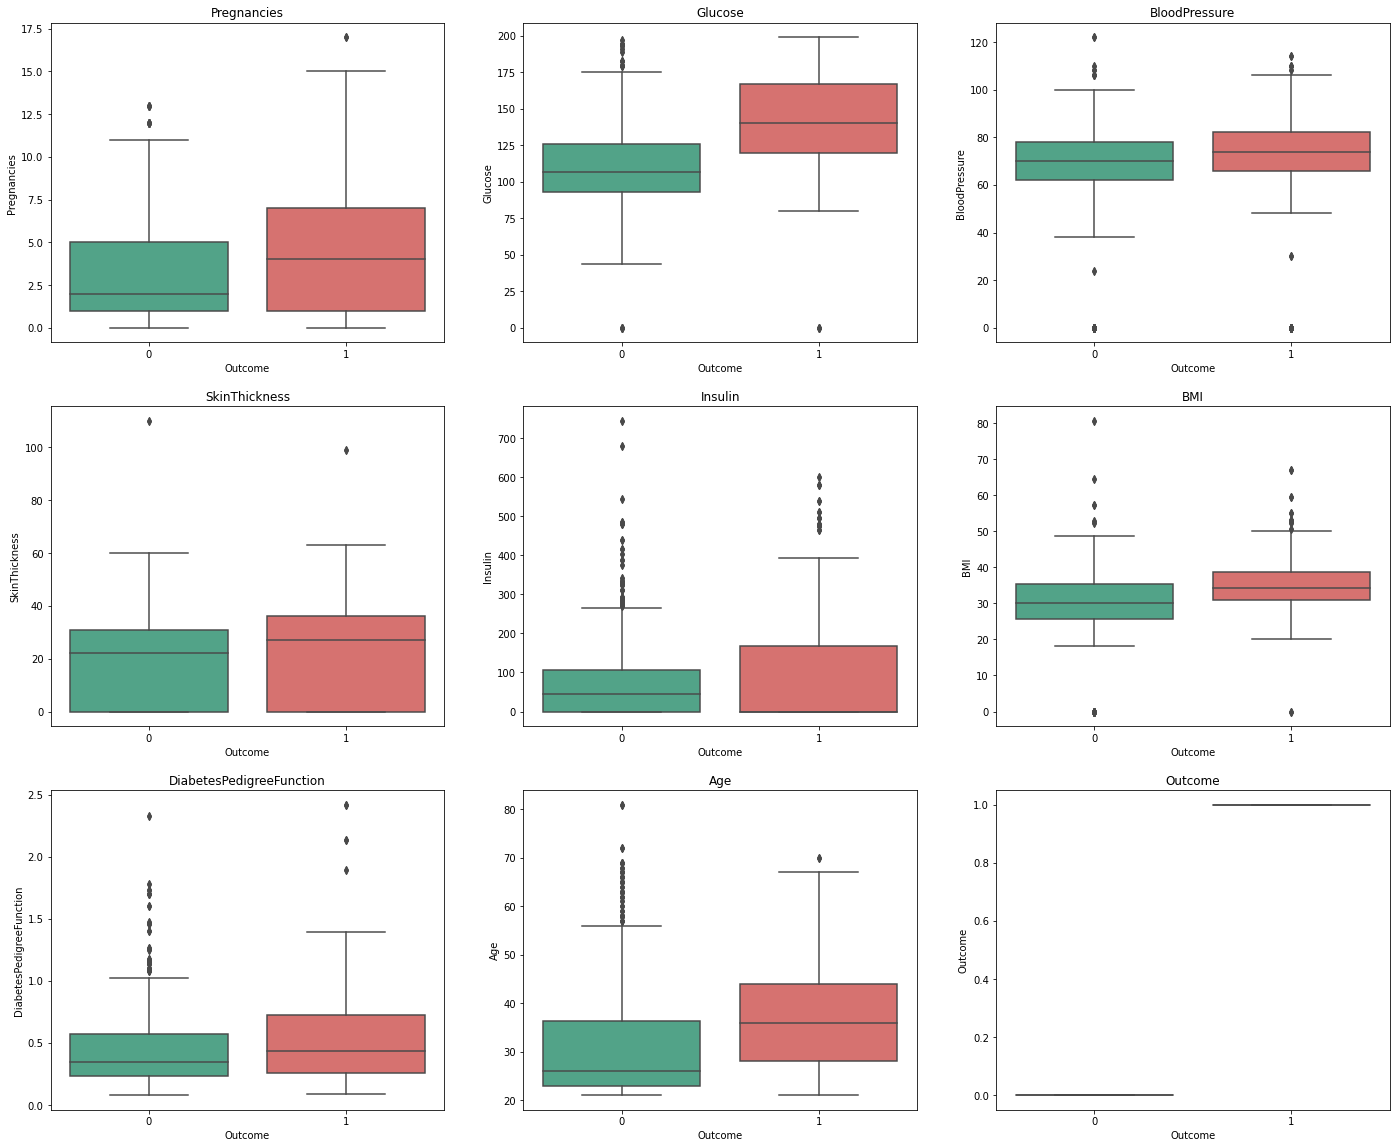

In [33]:
# Boxplots (perfil dividido entre pacientes com e sem diabetes)
plt.figure(figsize=(24,20))

for i, coluna in enumerate(colunas_lt):
    plt.subplot(3,3,i+1)
    g = sns.boxplot(x = df['Outcome'], y = df[coluna], palette = ['#45B08C','#E7625F'] )    
    g.set_title(coluna)

plt.show()

- Agora conseguimos avaliar de maneira mais direcionada nossos dados
- Via de regra, vejo que os gráficos de caixa referentes aos pacientes com diabetes estão levemente acima dos gráficos referentes aos pacientes sem diabetes, é possível ver essa tendência mais claramente nas colunas 'Glucose' e 'Age'

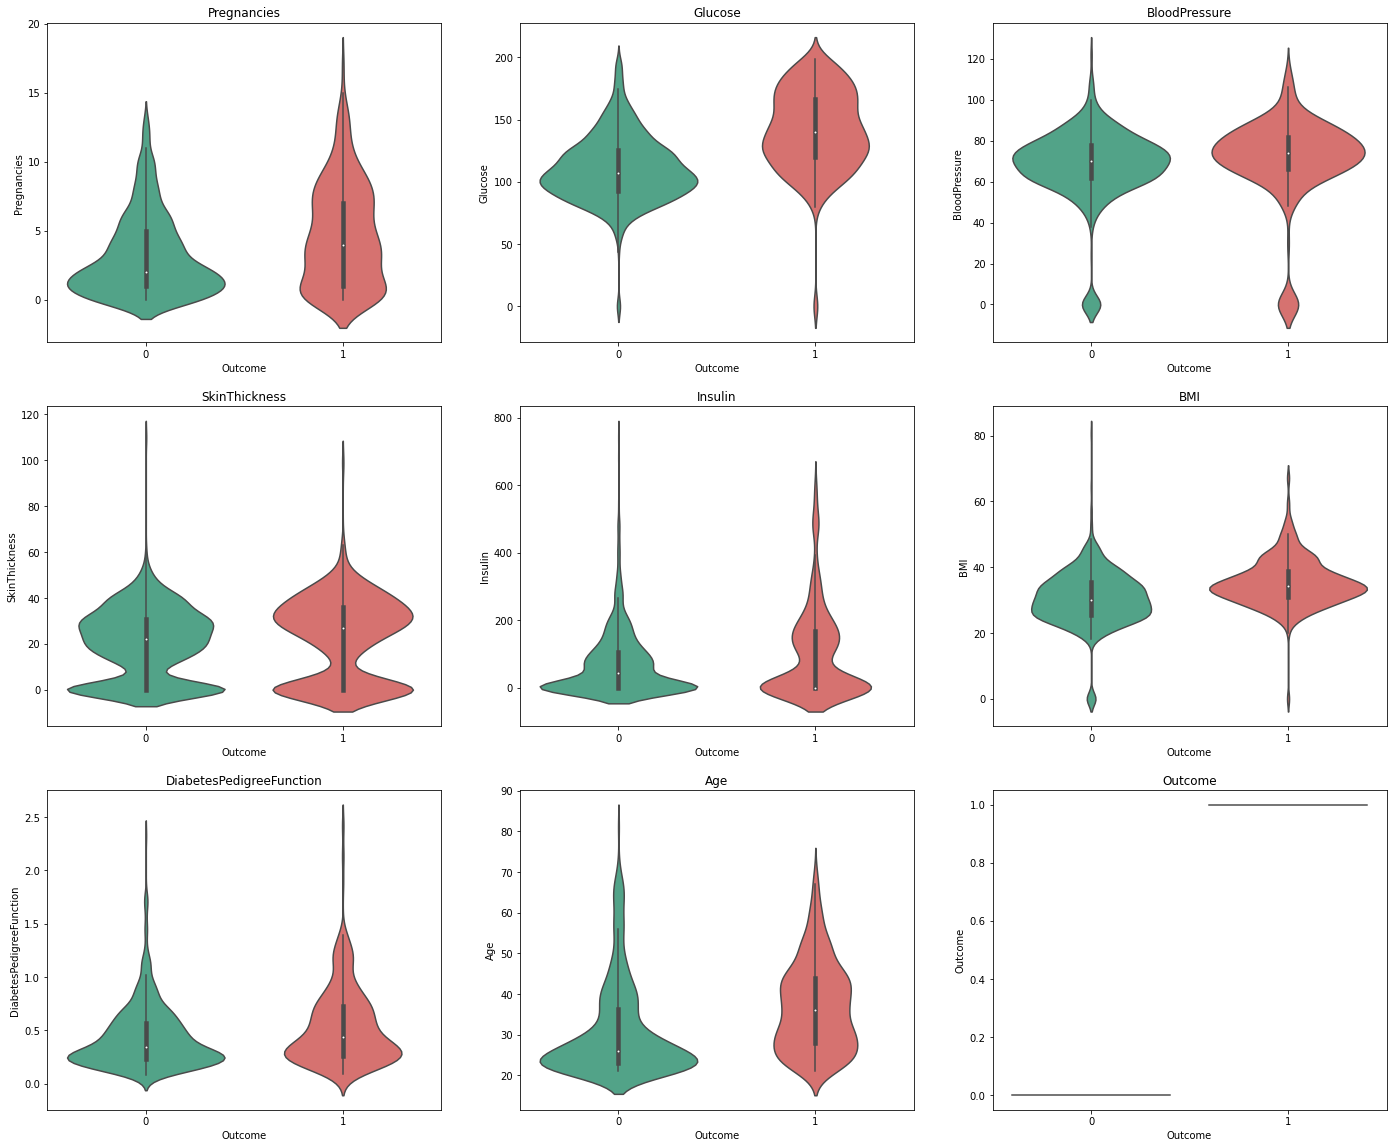

In [34]:
# Gráficos 'violin'
plt.figure(figsize=(24,20))

for i, coluna in enumerate(colunas_lt):
    plt.subplot(3,3,i+1)
    g = sns.violinplot(x = df['Outcome'], y = df[coluna], palette = ['#45B08C','#E7625F'] )    
    g.set_title(coluna)

plt.show()

- Novamente o perfil dos gráficos da coluna 'Glucose' e 'Age' ficaram com perfis distintos
- A coluna 'Pregnancies' também apresentou gráficos distintos, aparentemente mulheres com maior número de gravidez possuem uma certa tendência em desenvolverem um quadro de diabetes

### Glucose x Age
- Vamos verificar um pouco mais a fundo a relação glicose x idade 

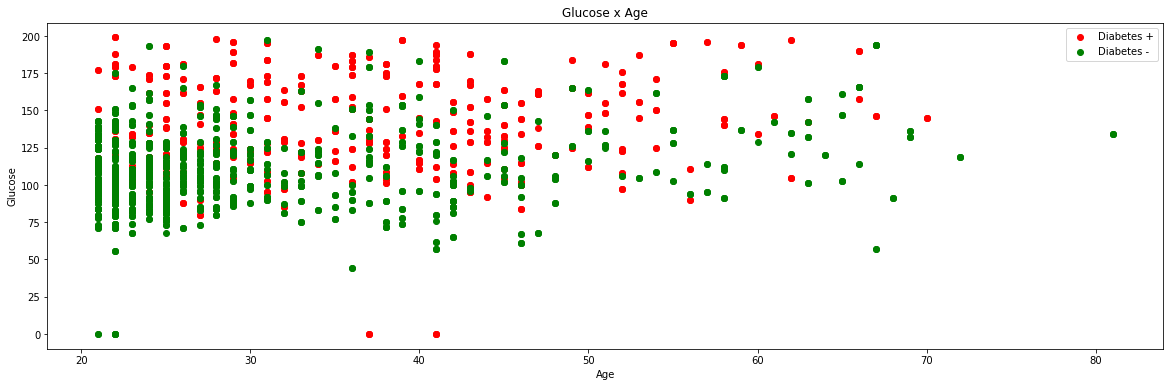

In [35]:
plt.figure(figsize=(20,6))

plt.scatter(x= diabetes_pos_df['Age'], y= diabetes_pos_df['Glucose'], color = 'r', label = 'Diabetes +')
plt.scatter(x= diabetes_neg_df['Age'], y= diabetes_neg_df['Glucose'], color = 'g', label = 'Diabetes -')

plt.title('Glucose x Age')
plt.xlabel('Age')
plt.ylabel('Glucose')
plt.legend()
plt.show()

# Modelos de Previsão

- Nessa etapa iremos treinar 3 modelos de classificação:
    1. ANN — Multi-Layer Perceptron
    2. Decision Tree Classifier
    3. SVM Classifier
- O objetivo dessa etapa é investigar o impacto de dois fatores na acurácia dos modelos
    1. Cross Validation
    2. Standard Scaler

In [36]:
# Nesse passo estamos dividindo nossa base em 2
# Os valores em X não contem a informação 'Outcome' que serão encontrados apenas na variável Y
X = df.drop(columns=['Outcome'])
Y = df['Outcome']

from sklearn.model_selection import train_test_split
#Split into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=i)

### Imbalanced Data
- Nesse projeto vou abordar um assunto novo, sobre dados desbalanceados
- Como era de se esperar, temos muto mais pacientes sem diabetes. Isso pode ser um problema, em casos mais extremo em que nossa classe de interesse é muito pouco frequente

##### Oversampling x Undersamplib
- Essas duas abordagens são formas de equilibrar a quantidade de amostras da classe minoritária e majoritária. Podemos então aumentar a quantidade de amostras da classe com menos aparições ou diminuir a quantidade de amostras da classe com mais aparições
- Oversampling: Aumenta a quantidade de amostras da classe com menos aparições
- Undersampling: Diminui a quantidade de amostras da classe com mais aparições

In [37]:
# Usaremos o método de Oversampling chamado 'SMOTE'
# Synthetic Minority Over-sampling Technique, é uma técnica que gera novas amostras interpolando amostras originais da minha base

from imblearn.over_sampling import SMOTE
# Oversampling
X_train, y_train = SMOTE().fit_resample(X_train, y_train)

### Padronização de Dados
- Esse processo tem como objetivo evitar que nosso modelo fique enviesado
- Isso pode ocorrer em função da diferença entre ordens de grandeza presentes na minha base de dados
- A técnica de padronização transformar todas as variáveis na mesma ordem de grandeza
- Padronizar as variáveis irá resultar em uma média igual a 0 entre os valores presentes e um desvio padrão igual a 1

In [38]:
# Vamos dividir nossa base em 2
# Em uma vamos aplicar o rpocesso de padronização e na outra não
# No final vamos ver qual o impacto dessa etapa na acurácia final do modelo

X1_train = X_train.copy()
y1_train = y_train.copy()
X1_test = X_test.copy()
y1_test = y_test.copy()

from sklearn.preprocessing import StandardScaler
# Padronizando os dados com o comando Standard Scaler
scaler = StandardScaler()  
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 

- Nessa etapa vamos fazer o treinamento dos modelos em 4 grupos:
    1. Grupo ss: dados sem cross validation e  padronizados com comando Standard Scaler
    2. Grupo cvss: dados com cross validation e padronizados com comando Standard Scaler
    3. Grupo : dados sem cross validation e não padronizados 
    4. Grupo cv: dados com cross validation e não padronizados

### Sem Cross Validation / Com Standard Scaler

In [39]:
mlpc = MLPClassifier(max_iter = 1000)
dt = DecisionTreeClassifier()
svc = SVC(gamma='auto')

modelos_lt = [mlpc, dt, svc]
modelos_ss =[]

for modelo in modelos_lt:
    modelo.fit(X_train, y_train)
    target_pred = modelo.predict(X_test)
    modelos_ss.append(accuracy_score(y_test,target_pred))
    
acc_res = pd.DataFrame({"Acurácia":modelos_ss,
                       "Algorithm":["ANN- MLP Classifier","Decision Tree Classifier", "SVM Classifier"]})  
display(acc_res)
print(modelos_ss)

C:\Users\user\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


,Acurácia,Algorithm
0,0.9375,ANN- MLP Classifier
1,0.9625,Decision Tree Classifier
2,0.8500,SVM Classifier


[0.9375, 0.9625, 0.85]


### Com Cross Validation / Com Standard Scaler

In [40]:
kfold = StratifiedKFold(n_splits=10)
random_state = 2

mlpc = MLPClassifier(random_state=random_state)
dt = DecisionTreeClassifier(random_state=random_state)
svc = SVC(gamma='auto', random_state=random_state)

modelos_lt = [mlpc, dt, svc]
cross_validation_ss = []
modelos_cvss = []
modelos_std = []

for modelo in modelos_lt:
    cv = cross_val_score(modelo, X_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=4)
    cross_validation_ss.append(cv)
    modelos_cvss.append(cv.mean())
    modelos_std.append(cv.std())
    
    
cv_res = pd.DataFrame({"CrossValMeans":modelos_cvss,
                       "CrossValerrors": modelos_std,
                       "Algorithm":["ANN- MLP Classifier","Decision Tree Classifier", "SVM Classifier"]})

display(cv_res)
print(modelos_cvss)

,CrossValMeans,CrossValerrors,Algorithm
0,0.841117,0.029749,ANN- MLP Classifier
1,0.949095,0.012790,Decision Tree Classifier
2,0.828750,0.029559,SVM Classifier


[0.8411171293161814, 0.9490950124125479, 0.8287497178966372]


### Sem Cross Validation / Sem Standard Scaler

In [41]:
mlpc = MLPClassifier(max_iter = 1000)
dt = DecisionTreeClassifier()
svc = SVC(gamma='auto')

modelos_lt = [mlpc, dt, svc]
# sss --> sem standard scaler
modelos =[]

for modelo in modelos_lt:
    modelo.fit(X1_train, y1_train)
    target_pred = modelo.predict(X1_test)
    modelos.append(accuracy_score(y1_test,target_pred))
    
acc_res = pd.DataFrame({"Acurácia":modelos,
                       "Algorithm":["ANN- MLP Classifier","Decision Tree Classifier", "SVM Classifier"]})  
display(acc_res)
print(modelos)

,Acurácia,Algorithm
0,0.8400,ANN- MLP Classifier
1,0.9625,Decision Tree Classifier
2,0.9900,SVM Classifier


[0.84, 0.9625, 0.99]


### Com Cross Validation / Sem Standard Scaler

In [42]:
mlpc = MLPClassifier(random_state=random_state)
dt = DecisionTreeClassifier(random_state=random_state)
svc = SVC(gamma='auto', random_state=random_state)

modelos_lt = [mlpc, dt, svc]
cross_validation = []
modelos_cv = []
modelos_std = []

for modelo in modelos_lt:
    cv = cross_val_score(modelo, X1_train, y = y1_train, scoring = "accuracy", cv = kfold, n_jobs=4)
    cross_validation.append(cv)
    modelos_cv.append(cv.mean())
    modelos_std.append(cv.std())
    
    
cv_res = pd.DataFrame({"CrossValMeans":modelos_cv,
                       "CrossValerrors": modelos_std,
                       "Algorithm":["ANN- MLP Classifier","Decision Tree Classifier", "SVM Classifier"]})

display(cv_res)
print(modelos_cv)

,CrossValMeans,CrossValerrors,Algorithm
0,0.778301,0.037173,ANN- MLP Classifier
1,0.948617,0.013945,Decision Tree Classifier
2,0.925272,0.032340,SVM Classifier


[0.7783006093432634, 0.9486165651094561, 0.9252719476416159]


### Análise de impacto Cross Validation x Standar Scale

,Sem Altereções,Standard Scaler,Cross Validation,Cross Validation + Standard Scaler
ANN- MLP Classifier,0.8400,0.9375,0.778301,0.841117
Decision Tree Classifier,0.9625,0.9625,0.948617,0.949095
SVM Classifier,0.9900,0.8500,0.925272,0.828750


<Figure size 1440x432 with 0 Axes>

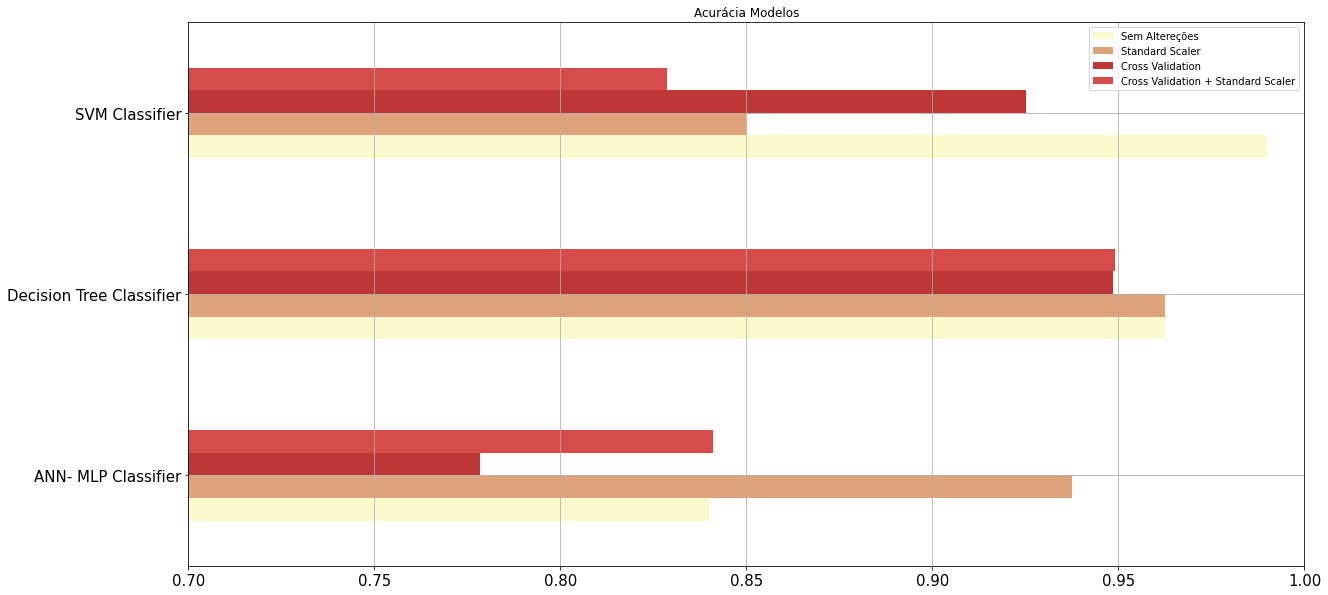

In [43]:
nome_modelos = ["ANN- MLP Classifier","Decision Tree Classifier", "SVM Classifier"]

plt.figure(figsize=(20,6))

df = pd.DataFrame({'Sem Altereções':modelos,
                   'Standard Scaler':modelos_ss, 
                   'Cross Validation':modelos_cv,
                   'Cross Validation + Standard Scaler':modelos_cvss,
                    }, index = nome_modelos)

display(df)
df.plot(kind = 'barh',
        rot = 0,
        fontsize = 15,
        title = 'Acurácia Modelos',
        color =['#fcf9ce','#dea37a','#bd3737','#d54c4a'],
        grid = True,
        xlim = [0.7,1],
        figsize = (20,10))

plt.show()

- Podemos tirar informações valiosas do gráfico da acurácia dos modelos
- Está nítido que para alguns modelos a padronização melhorou a acurácia e para outros não, ainda temos o caso que a padronização aparentemente não impactou no resultado.
        Considerando os dados com cross validation:
            1. SVM Classifier: O modelo com padronização teve um resuldado INFERIOR ou modelo sem a padronização
            2. Decision Tree Classifier: Aparentemente a padronização dos dados não teve grande impacto no modelo
            3. ANN-MLP Classifier: A padronização teve um impacto positivo na criação do modelo
- Sobre o processo de Cross Validation, vemos que os resultados com e sem cross validation diferente bastante, isso mostra a importância de aplicar esse procedimento ao treinar modelos de machine learning. Isso evita que nos precipitemos em afirmar que um modelo está ou não eficiente. Vamos ver um pouco mais a fundo sobre os enganos que podemos cometer ao pular essa etapa.       

### Análise Cross Validation

- Nessa etapa vamos verificar todos os valores encontrados no processo de cross validation de alguns dos modelos que treinamos<br>


- Durante o processo de treinamento de um modelo são separados os dados de treinos e os dados de teste. Mas e se a forma como os dados forem separados impactar de alguma forma o resultado? Para isso existe o processo de cross validation, separamos nossa base várias vezes em diferentes dados de treino e dados de teste, e para cada vez verificamos a acurácia. Diferentes valores de acurácia serão obtidos, assim podemos fazer a média deles para ter um valor final mais confiável   

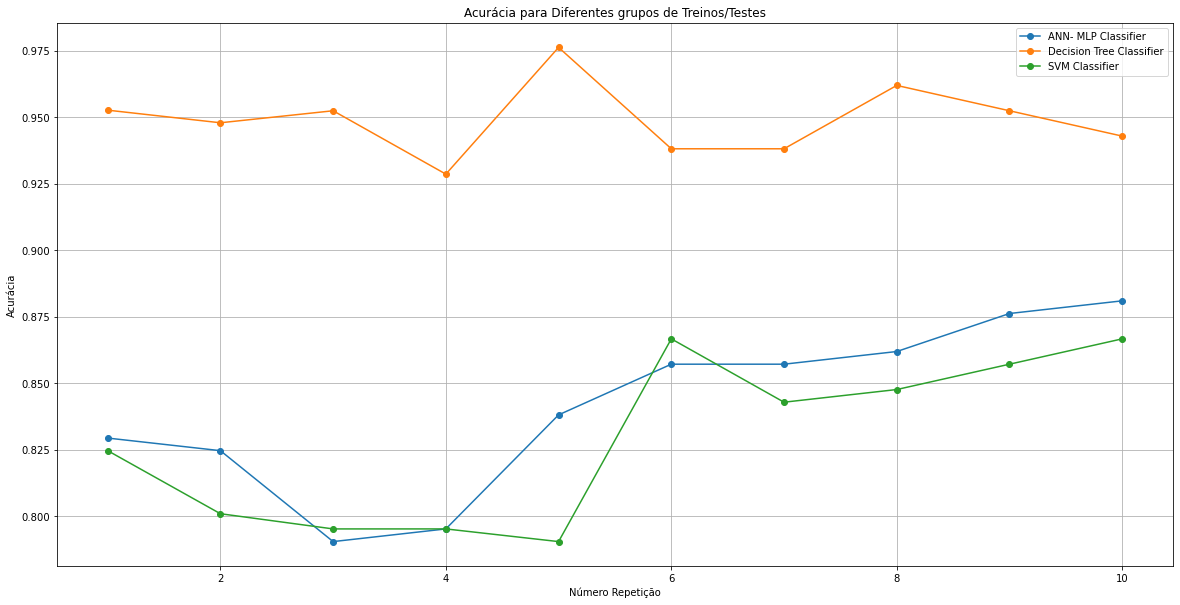

In [44]:
# Análise dos Modelos com Dados Padronizados

plt.figure(figsize = (20,10))
x = [i for i in range(1,11)]

for i in range(0,3):
    plt.plot(x, cross_validation_ss[i],'-o', label = nome_modelos[i])

plt.xlabel("Número Repetição")  
plt.ylabel("Acurácia") 
plt.legend()
plt.title("Acurácia para Diferentes grupos de Treinos/Testes")
plt.grid()

plt.show() 

### Variação Percentual Máxima
- Vamos analisar até quanto nossos modelos variaram durante o processo de cross validation
- a variação percentual máxima será calculada através da seguinte equação:

    vpm = (máx - mín) / mín

In [45]:
vmp = [(item.max()-item.min())/item.min() for item in cross_validation_ss]
for i in range(0,3):
    print(f'A variação percentual máxima do modelo {nome_modelos[i]} foi de : {vmp[i]:.2%}')

A variação percentual máxima do modelo ANN- MLP Classifier foi de : 11.45%
A variação percentual máxima do modelo Decision Tree Classifier foi de : 5.13%
A variação percentual máxima do modelo SVM Classifier foi de : 9.64%


- O gráfico com os diferentes valores de acurácia obtidos em função de diferentes separações da nossa base em dados de treino e teste mostra como os parâmetros podem variar bastante apenas com uma divisão de dados diferente.
- Os valores de acurácia chegaram a ter uma variação de mais de 11%, como foi o caso do modelo SVM-Classifier

# Análise melhor modelo

- O melhor modelo foi o de Decision Tree
- Vamos usar a versão SEM padronização de dados pois foi verificado um baixo impacto dessa função na acurácia do modelo

,0
Glucose,0.305884
BMI,0.210253
Age,0.143512
DiabetesPedigreeFunction,0.138812
Insulin,0.071099
SkinThickness,0.048503
Pregnancies,0.047474
BloodPressure,0.034463


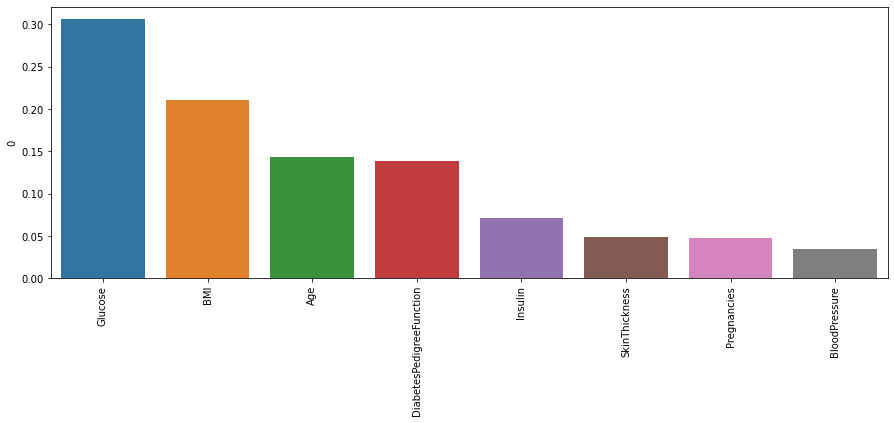

In [63]:
# Treinando o modelo
dt = DecisionTreeClassifier()
dt.fit(X1_train, y1_train)
# Análise modelo
importancia_features = pd.DataFrame(dt.feature_importances_, X1_train.columns)
importancia_features = importancia_features.sort_values(by=0, ascending=False)
display(importancia_features)
plt.figure(figsize=(15, 5))
ax = sns.barplot(x=importancia_features.index, y=importancia_features[0])
ax.tick_params(axis='x', rotation=90)

- Como suspeitávamos a coluna 'Glucose' teve grande impacto no modelo
- Aparetemente todas as colunas tiveram algum impacto mesmo que pequeno, como a coluna de BloodPressure

# Conclusão

- O melhor modelo foi o 'Decision Tree Classifier', com uma acurácia beirando os 95%
- Como ponto positivo do projeto foi possível estudar de maneira mais aprofundada os conceitos de Oversamplig x Undersampling e Padronização x Normalização
- A etapa de tratamento de dados não foi necessária devido a natureza dos dados, isso simplificou muito o projeto
- Foi possível verificar o impacto de fazer cross validation nos modelos, além disso essa é uma etapa muito importante também para um futuro objeto de estudo 'Overfitting x Underfitting'
- Contato com um novo modelo de classificação 'ANN- MLP Classifier'
- Meta: Iniciar os estudos de modelos de clusterização